# Extrasolar Planet Analysis

I base the following analysis from my lecture notes from the following Udemy courses: 

***Machine Learning in Python Level 1: Beginner*** by Hadelin de Ponteves and Kirill Eremenko

***Machine Learning Classification Bootcamp in Python*** by Dr. Ryan Ahmed, Ph.D., MBA (in progress)

***Python for Data Science and Machine Learning Bootcamp*** by Jose Portilla

as well as chunks of code gleaned from similar studies on Kaggle.

I first recreate the following figure from **The Essential Cosmic Perspective, 7th Edition** Figure 10.13. I would like to include all/any new data just test my clustering skills. I am not convinced I'll learn anything new scientifically, but this will give me an opportunity to clean up a data set and test a few data science skills I have learned.

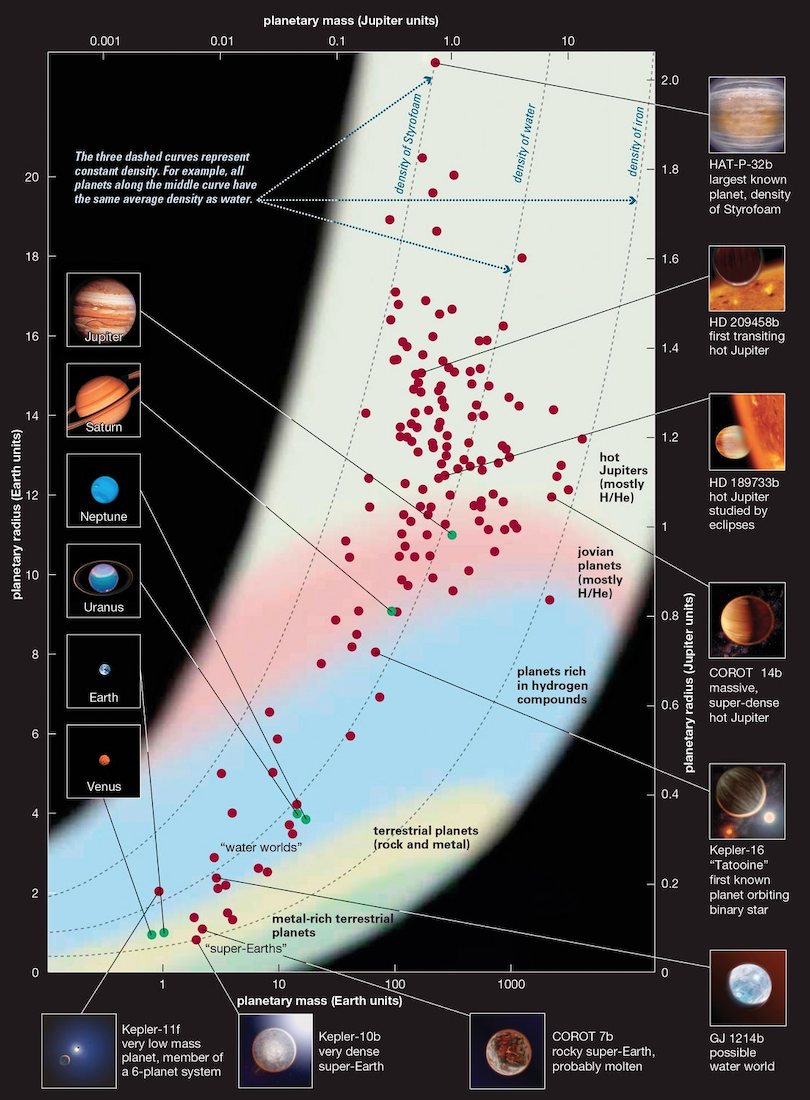

This figure popped into my mind when I thought about K-means Clustering in ***Machine Learning in Python Level 1: Beginner***. In particular, I wanted to see if clusering algorithms could find interesting groups of planets in this graph (updated with recent observations) - and perhaps *if* that clusetering provided any insight into planetary system properties.

First and foremost I want to state that my academic background is astrophysics. I did my undergraduate research in observing such planetary systems (using the *transit method*, mentioned next). However my graduate school opportunities in planets didn't pan out and I left that field entirely behind to study galaxies and galaxy evolution, a completely different size scale of the universe with exactly no overlap in content (exception, studying molecular gas). It was only at one of my temparary teaching positions I was able to help undergradute students do similar research projects, as well as cover this material in introductory astronomy for non-STEM student courses. It was fun to put this hat on again, if it was only brief in time, but gave me a fun idea to do some analysis.

Thus, I am acutely aware that this project is of little academic value to the field - but if you study this and find this is interesting - send me a message and let's write this up in a journal! This analysis is entirely for practicing my Data Science and Machine Learning skills, blemishes and all, so that people will consider hiring me to do such things with non-astronomy data.

## Crashcourse - Exoplanets:

It comes as a surprise to many that we actually do not directly image planets orbiting other stars all the often. In fact we only have ~60-70 confirmed images of exoplanets (stated on the website this data is sourced from). We detect planets around other stars primary through indirect methods. 

The ***transit method*** looks for eclipses of the planet passinging in front of the parent star. It is important to note here that we still are not directly imaging the planet NOR are we seeing this eclipse in the way we see solar/lunar/Venus/etc. eclipses on Earth. We simply measure the drop in brightness of the parent star. Through physics, we can turn that drop into the **radius of the planet** $R_{\rm planet}$ when we also know information about the star (which is another discussion, but for this study assume that is usually the case for these systems). The frequency with which these transits occur tell us the **period** $P$, and through a relationship called Kepler's 3rd Law, (${\rm Period})^2 \propto ({\rm Semi-Major \  Axis})^3$, we can determine the **semi-major axis** $a$. The semi-major axis is, for nearly circular systems, approximately the average distance between the planet and the star (elliptical systems this relates to the longest half-axis, not important for this analysis).

***Radial velocity*** (or ***RV***) method uses the doppler method (through spectral features (like emission/absortion lines) in the parent star's spectra) to discover planets due to the gravitational *wobble* of a planetary system around the parent star. This method also returns the **period** (and thus semi-major axis) when observed more than once, but this wobble gives the **mass of the planet** $M_{\rm planet}$ - well kind of. This method can not on it's own identify the inclination (parameterized by angle $i$), and thus this method only gives $M_{\rm planet} \sin i$ when $i$ can not be determined.

Thus to make the graph above, we need to isolate *only* systems that have *both* of these independent observations.

## The dataset

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PSCompPars

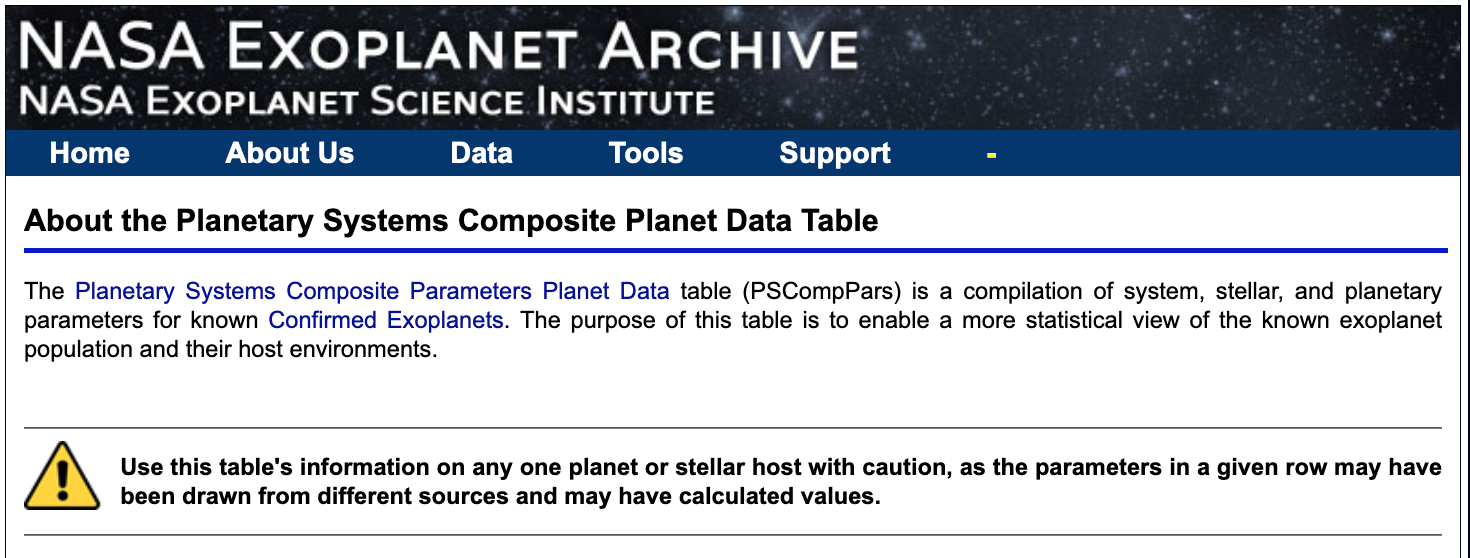

The data we are starting with is an already slimmed down library of observed exoplanets. In the parent data repository, every planet listed in the table could have several entries that measure different sets of parameters in different (perhaps inconsistent) ways. The table we are using is essentially a flat version of this, collapsing all of the data given to one entry per target, but it is removing data that is double entered - regardless of agreement. Thus, there is a lot of build in uncertainty to just using this table. To do a *real* scientific analysis would require a proper collapsing of all of these enteries, justifying why you might pick one study over another for double listed data, etc. - something that is far beyond the scope (or want) of this project.

## Importing the dataset 
#### Based On *Machine Learning in Python Level 1: Beginner*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
#### Header from the original csv.

#### This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
#### Sun Feb 26 13:35:18 2023
####
#### User preference: *
####
#### COLUMN pl_name:        Planet Name
#### COLUMN hostname:       Host Name
#### COLUMN sy_snum:        Number of Stars
#### COLUMN sy_pnum:        Number of Planets
#### COLUMN discoverymethod: Discovery Method
#### COLUMN disc_year:      Discovery Year
#### COLUMN disc_facility:  Discovery Facility
#### COLUMN rv_flag:        Detected by Radial Velocity Variations
#### COLUMN tran_flag:      Detected by Transits
#### COLUMN pl_controv_flag: Controversial Flag
#### COLUMN pl_orbper:      Orbital Period [days]
#### COLUMN pl_orbsmax:     Orbit Semi-Major Axis [au])
#### COLUMN pl_rade:        Planet Radius [Earth Radius]
#### COLUMN pl_radj:        Planet Radius [Jupiter Radius]
#### COLUMN pl_bmasse:      Planet Mass or Mass*sin(i) [Earth Mass]
#### COLUMN pl_bmassj:      Planet Mass or Mass*sin(i) [Jupiter Mass]
#### COLUMN pl_bmassprov:   Planet Mass or Mass*sin(i) Provenance
#### COLUMN pl_orbeccen:    Eccentricity
#### COLUMN pl_insol:       Insolation Flux [Earth Flux]
#### COLUMN pl_eqt:         Equilibrium Temperature [K]
#### COLUMN ttv_flag:       Data show Transit Timing Variations
#### COLUMN st_spectype:    Spectral Type
#### COLUMN st_teff:        Stellar Effective Temperature [K]
#### COLUMN st_rad:         Stellar Radius [Solar Radius]
#### COLUMN st_mass:        Stellar Mass [Solar mass]
#### COLUMN st_met:         Stellar Metallicity [dex]
#### COLUMN st_metratio:    Stellar Metallicity Ratio
#### COLUMN st_logg:        Stellar Surface Gravity [log10(cm/s**2)]
#### COLUMN rastr:          RA [sexagesimal]
#### COLUMN ra:             RA [deg]
#### COLUMN decstr:         Dec [sexagesimal]
#### COLUMN dec:            Dec [deg]
#### COLUMN sy_dist:        Distance [pc]

In [3]:
df_big = pd.read_csv('PSCompPars_2023.02.26_13.35.18.csv')#, sep=',', on_bad_lines='skip')

As the original figure used $\log_{10} M_{\rm planet}$ and $\log_{10} R_{\rm planet}$, add these to the dataset. Also added density while I was at it. Also added $\log_{10}$ of other things (for analysis later).

In [4]:
df_big['log_pl_bmasse'] = np.log10(df_big['pl_bmasse'].iloc[:].values)
df_big['log_pl_rade'] = np.log10(df_big['pl_rade'].iloc[:].values)
densitye = df_big['pl_bmasse'].iloc[:].values / ((4/3)*(df_big['pl_rade'].iloc[:].values)**3.)
df_big['pl_densitye'] = densitye
df_big['log_pl_densitye'] = np.log10(df_big['pl_densitye'].iloc[:].values)
df_big['log_pl_orbper']= np.log10(df_big['pl_orbper'].iloc[:].values)
df_big['log_pl_orbsmax']= np.log10(df_big['pl_orbsmax'].iloc[:].values)
df_big['log_st_mass']= np.log10(df_big['st_mass'].iloc[:].values)

Create Density Classes https://arxiv.org/abs/1612.03556

The classes in the previous image are not shared in an easily obtainable way. I rather decided to do coarse classifications (at least for now) to identify planets by their densities. This also allows us to remove objects like Brown Dwarf Stars ('failed' stars) that might present themselves here.

Taking their proposed classifications, and stretching the edges since they don't overlap.

Ice/gas giant: $\rho < \approx 2.85$ $\frac{g}{cm^3}$ 

Iron/Rock: $ 2.85 \frac{g}{cm^3} < \approx \rho < \approx 19.2 \frac{g}{cm^3}$

Degenerate (Brown Dwarf): $\rho > \approx 19.2 \frac{g}{cm^3}$ - failed stars

1 $\frac{M_{Earth}}{R_{Earth}^3}$ = 17.32 $\frac{g}{cm^3}$

In [18]:
df_big['pl_class'] = df_big['pl_name']

pl_densitye = df_big['pl_densitye'].iloc[:].values
pl_class = df_big['pl_name'].iloc[:].values #dummy variables

den = 17.32

pl_class[(pl_densitye*den <= 2.85)] = 'Jovian'
pl_class[(pl_densitye*den > 2.85) & (pl_densitye*den <= 19.2)] = 'Terrestrial'
pl_class[(pl_densitye*den > 19.2)] = 'BrownDwarf'
df_big['pl_class'] = pl_class

In [6]:
#for col in df_big.columns:
#    print(col)

In [7]:
# Grab systems where both transit and RV methods are detected.
#Get Rid of Brown Dwarfs
#also get rid of missing data
#df_detect = df_big[(df_big['rv_flag'] == 1) & (df_big['tran_flag'] == 1)]
df_detect = df_big[(df_big['rv_flag'] == 1) & (df_big['tran_flag'] == 1) & (df_big['pl_densitye'] <= 19.2/den)]

df_detect = df_detect.dropna(subset=['log_pl_bmasse', 'log_pl_rade','log_pl_densitye','log_pl_orbper','log_pl_orbsmax','st_teff', 'log_st_mass','pl_class'])

In [8]:
df = df_detect[['pl_name','log_pl_bmasse','log_pl_rade','log_pl_densitye','log_pl_orbper', 'log_pl_orbsmax', 'st_teff', 'log_st_mass', 'pl_class']]

In [9]:
#Uncomment if you want to make a new masterfile
##df.to_csv('exoplanet_cleaned.csv',index=False)

### Explore Data - My Work 

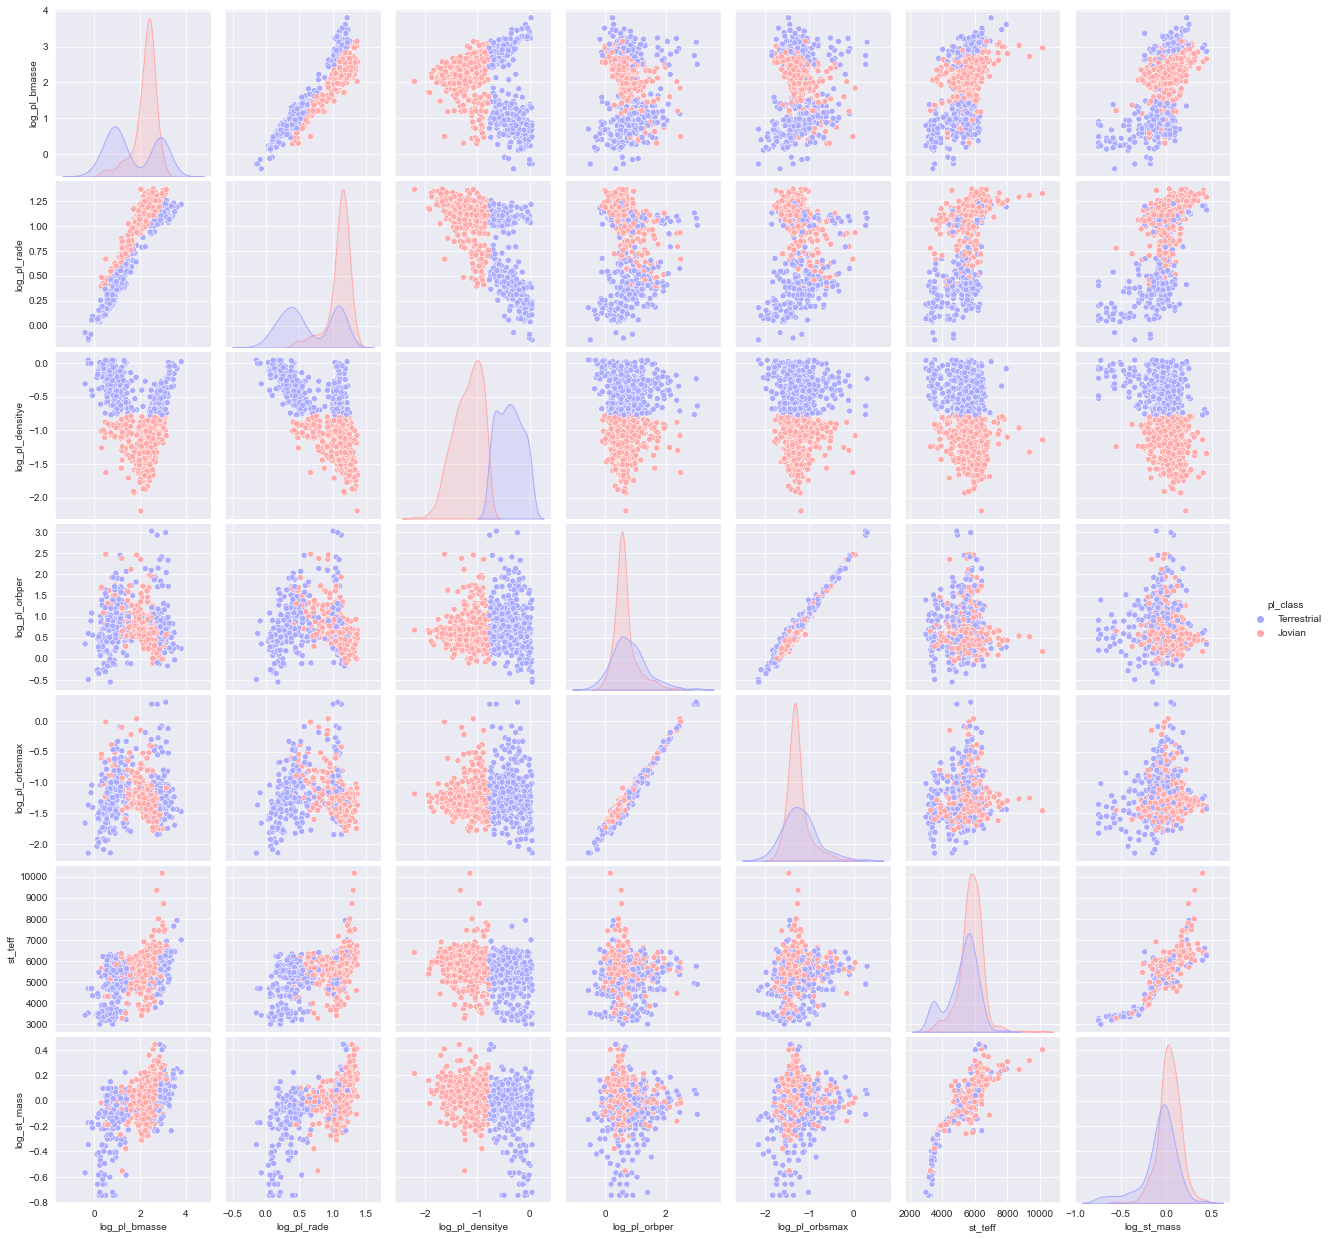

In [15]:
sns.pairplot(df,palette='bwr',hue='pl_class')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


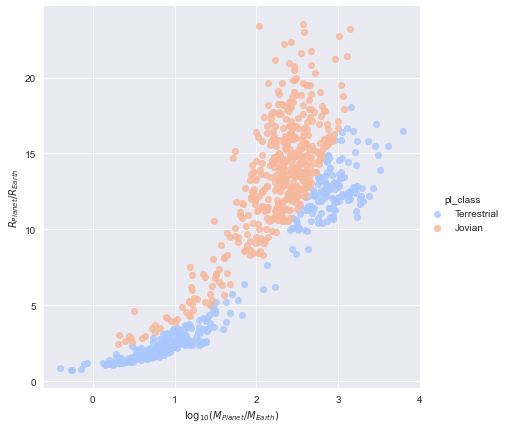

In [17]:
sns.set_style('darkgrid')
ax = sns.lmplot(x = 'log_pl_bmasse',y = 'pl_rade',data=df_detect, hue='pl_class',
           palette='coolwarm',size=6,aspect=1,fit_reg=False)
ax.set(xlabel='$\log_{10} (M_{Planet} / M_{Earth})$', ylabel='$R_{Planet} / R_{Earth}$')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


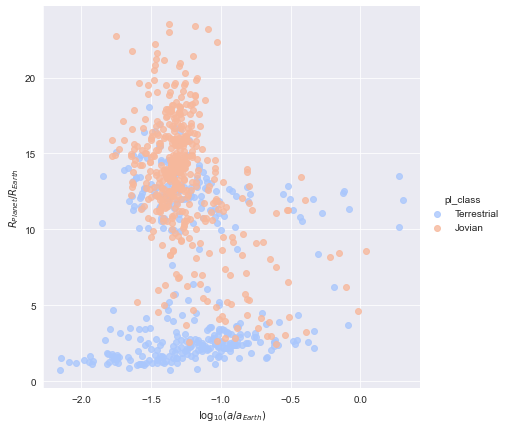

In [21]:
sns.set_style('darkgrid')
ax = sns.lmplot(x = 'log_pl_orbsmax',y = 'pl_rade',data=df_detect, hue='pl_class',
           palette='coolwarm',size=6,aspect=1,fit_reg=False)
ax.set(xlabel='$\log_{10} (a / a_{Earth})$', ylabel='$R_{Planet} / R_{Earth}$')